In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["CustomerID",'Churn_Label'], inplace = True, axis = 1)
    
    df.Total_Charges = df.Total_Charges.replace(" ",np.nan)
    df.Total_Charges.fillna(0, inplace = True)
    df.Total_Charges = df.Total_Charges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'Paperless_Billing', 'Phone_Service']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.Gender = df.Gender.apply(lambda x: 0 if x == "Male" else 1)
    df.Multiple_Lines = df.Multiple_Lines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['Senior_Citizen','Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['Internet_Service', 'Contract', 'Payment_Method'], drop_first=True)
    
    return df

In [3]:
df = datapreparation(filepath = "Telco_Customer_Churn_Survival_Analysis.csv")
df.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Monthly_Charges,Total_Charges,Churn_Value,Internet_Service_Fiber optic,Internet_Service_No,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,1,0,1,0,9,1,0,0,1,0,...,65.6,593.30,0,0,0,1,0,0,0,1
1,0,0,0,0,9,1,1,0,0,0,...,59.9,542.40,0,0,0,0,0,0,0,1
2,0,0,0,0,4,1,0,0,0,1,...,73.9,280.85,1,1,0,0,0,0,1,0
3,0,1,1,0,13,1,0,0,1,1,...,98.0,1237.85,1,1,0,0,0,0,1,0
4,1,1,1,0,3,1,0,0,0,0,...,83.9,267.40,1,1,0,0,0,0,0,1


In [4]:
pd.isnull(df).sum()

Gender                                    0
Senior_Citizen                            0
Partner                                   0
Dependents                                0
Tenure_Months                             0
Phone_Service                             0
Multiple_Lines                            0
Online_Security                           0
Online_Backup                             0
Device_Protection                         0
Tech_Support                              0
Streaming_TV                              0
Streaming_Movies                          0
Paperless_Billing                         0
Monthly_Charges                           0
Total_Charges                             0
Churn_Value                               0
Internet_Service_Fiber optic              0
Internet_Service_No                       0
Contract_One year                         0
Contract_Two year                         0
Payment_Method_Credit card (automatic)    0
Payment_Method_Electronic check 

## Model Building

In [5]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OneHotEncoder 
from lifelines import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

### Random Forest Model

In [6]:
import sys
sys.path.append('test/KwaiSurvival')
from DeepSurv import *
from DeepHit import *
from DeepMultiTasks import *

In [7]:
x=df[['Gender','Senior_Citizen','Partner','Dependents','Phone_Service',
      'Multiple_Lines','Online_Security','Online_Backup','Device_Protection',
      'Tech_Support','Streaming_TV','Streaming_Movies','Paperless_Billing',
      'Monthly_Charges','Total_Charges',
      'Internet_Service_Fiber optic','Internet_Service_No','Contract_One year',
      'Contract_Two year','Payment_Method_Credit card (automatic)',
      'Payment_Method_Electronic check','Payment_Method_Mailed check']]
y=df["Churn_Value"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=99)

In [8]:
#SMOTE
print('before smote:','\n',pd.value_counts(y_train))
sm = SMOTE(random_state=1,sampling_strategy='auto',k_neighbors=5)
x_train, y_train= sm.fit_resample(x_train, y_train)
print('after smote:','\n',pd.value_counts(y_train))

before smote: 
 0    3622
1    1308
Name: Churn_Value, dtype: int64
after smote: 
 1    3622
0    3622
Name: Churn_Value, dtype: int64


In [24]:
#function for model fitting
def death_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols.columns.values)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))                  
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

## Hyperparameters Tuning 

def __init__(self, n_estimators=100, min_leaf=3, unique_deaths=3,
                 n_jobs=None, parallelization_backend="multiprocessing", oob_score=False)

A Random Survival Forest is a prediction model especially designed for survival analysis.

param n_estimators: The numbers of trees in the forest.

param min_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_leaf training samples in each of the left and right branches.

param unique_deaths: The minimum number of unique deaths required to be at a leaf node.

param n_jobs: The number of jobs to run in parallel for fit. None means 1.

#### Grid 1: Selecting class weight and estimators

In [25]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[300, 500, 700, 900, 1100, 1300]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [300, 500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [26]:
print(grid1.best_estimator_)

RandomForestClassifier(max_features='log2', n_estimators=1300)


<AxesSubplot:xlabel='param_max_features', ylabel='param_n_estimators'>

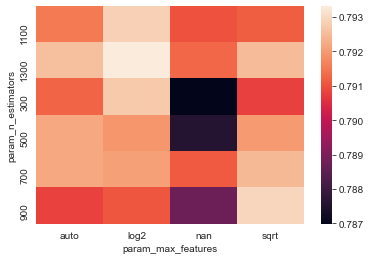

In [27]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [28]:
grid1.best_score_

0.7933090708827034

#### Grid 2: Selecting max depth and split criterion

In [33]:
param_grid2 = {'max_features':['log2'],
          'n_estimators':[1200,1300,1400],
           'criterion': ['entropy', 'gini'],    
          'max_depth': [7, 9, 11, 13],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, 17],
                         'max_features': ['log2'],
                         'n_estimators': [1200, 1300, 1400]},
             scoring='f1', verbose=1)

In [34]:
print(grid2.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       n_estimators=1200)


<AxesSubplot:xlabel='param_criterion', ylabel='param_max_depth'>

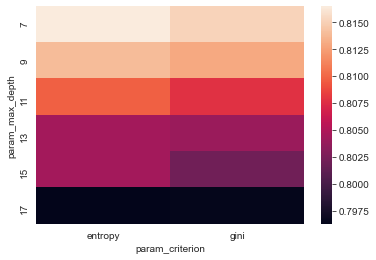

In [35]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')
     
sns.heatmap(table)

<AxesSubplot:xlabel='param_n_estimators', ylabel='param_max_depth'>

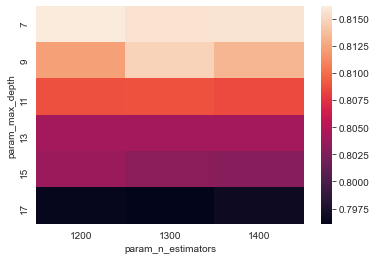

In [36]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_n_estimators')
     
sns.heatmap(table)

In [37]:
grid2.best_score_

0.8172573112008493

Checking if other depth and estimator value results better

In [39]:
param_grid2_2 = {'max_features':['log2'],
          'n_estimators':[1150,1200,1250],
           'criterion': ['entropy'],    
          'max_depth': [6, 7, 8],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [6, 7, 8],
                         'max_features': ['log2'],
                         'n_estimators': [1150, 1200, 1250]},
             scoring='f1', verbose=1)

In [40]:
print(grid2_2.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       n_estimators=1150)


<AxesSubplot:xlabel='param_n_estimators', ylabel='param_max_depth'>

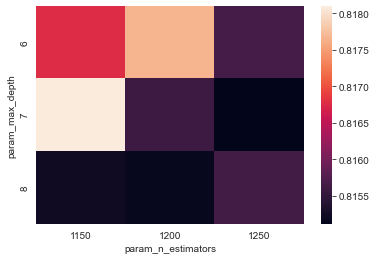

In [41]:
dt = pd.DataFrame(grid2_2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_n_estimators')
     
sns.heatmap(table)

In [42]:
grid2_2.best_score_

0.818096289697455

#### Grid 3: Selecting class weight

In [48]:
param_grid3 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
           'max_features':['log2'],
          'n_estimators':[1150],
           'criterion': ['entropy'],    
          'max_depth': [7],
            'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [4, 6, 8,10]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(x_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [7],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [4, 6, 8, 10],
                         'n_estimators': [1150]},
             scoring='f1', verbose=1)

In [49]:
print(grid3.best_estimator_)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=7, max_features='log2', min_samples_leaf=3,
                       min_samples_split=6, n_estimators=1150)


<AxesSubplot:ylabel='param_class_weight'>

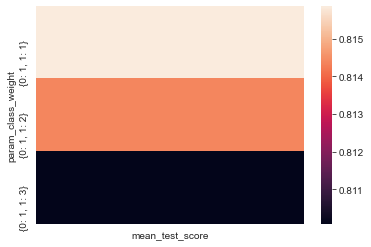

In [50]:
dt = pd.DataFrame(grid3.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [51]:
grid3.best_score_

0.8172725631331806

### Random Forest Model

In [52]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 1},
                       criterion='entropy', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,min_samples_leaf=3,min_samples_split=6,
                       min_impurity_decrease=0.0,min_weight_fraction_leaf=0.0, n_estimators=1150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False).fit(x_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=7, max_features='log2', min_samples_leaf=3,
                       min_samples_split=6, n_estimators=1150)

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.79      0.83      1552
           1       0.55      0.72      0.63       561

    accuracy                           0.77      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.77      0.78      2113

Accuracy   Score :  0.7695220066256507
Area under curve :  0.8403531984490142 



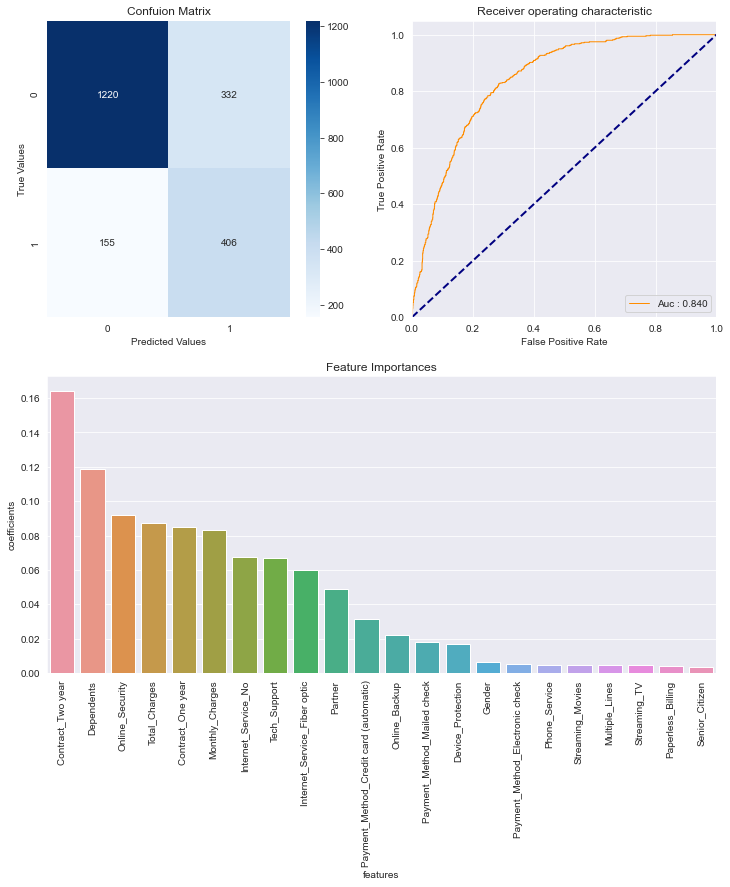

In [53]:
death_prediction(model, x_train, y_train, x_test, y_test, x,"features")

## Explaining the Random Forest Model

In [54]:
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x.columns.tolist())

Weight,Feature
0.0193 ± 0.0165,Contract_Two year
0.0188 ± 0.0111,Dependents
0.0152 ± 0.0113,Contract_One year
0.0147 ± 0.0090,Internet_Service_No
0.0079 ± 0.0071,Online_Security
0.0044 ± 0.0047,Payment_Method_Credit card (automatic)
0.0036 ± 0.0055,Tech_Support
0.0035 ± 0.0046,Internet_Service_Fiber optic
0.0034 ± 0.0042,Online_Backup
0.0016 ± 0.0036,Payment_Method_Mailed check


### Shap Values

https://blog.csdn.net/sinat_26917383/article/details/115400327

https://blog.csdn.net/sinat_26917383/article/details/115556182

https://zhuanlan.zhihu.com/p/85791430

In [55]:
import shap 
shap.initjs()

import joblib

In [62]:
explainer = shap.TreeExplainer(model)

In [56]:
shap_values = explainer.shap_values(np.array(x.iloc[47]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[47])

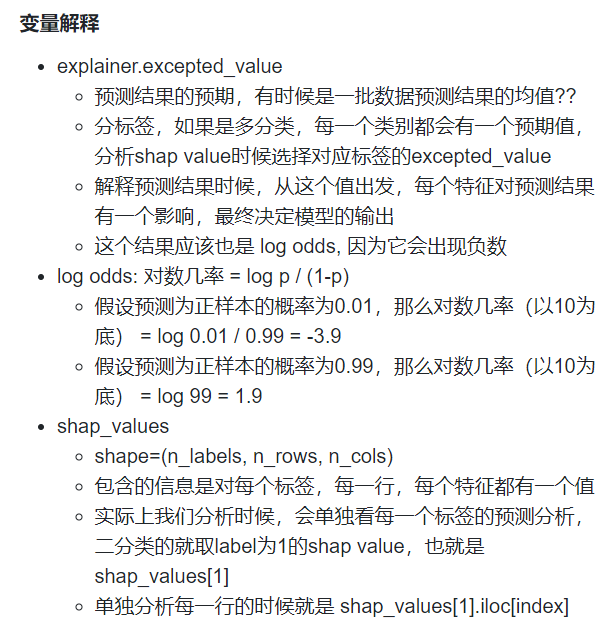

In [57]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x.iloc[92]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[92])

In [58]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x.iloc[687]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[687])

In [59]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x.iloc[200]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[200])

In [60]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x.iloc[380]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[380])

In [61]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x.iloc[146]))
shap.force_plot(explainer.expected_value[1], shap_values[1], x.iloc[146])